In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import seaborn as sns

In [2]:
plt.style.use("~/nice.mplstyle")

In [43]:
metric = "rmse"
subregion = ""

#error["Nested-EAGLE 1\u00B0/15km"] = xr.open_dataset(f"/pscratch/sd/t/timothys/nested-eagle/1.00deg-15km/mse24h/experiments/lr/lr1.00e-4/inference-validation/obs-metrics/{metric}.convobs.nested-global{subregion}.nc", decode_timedelta=True)
error["Nested-EAGLE 1\u00B0/15km"] = xr.load_dataset(f"/pscratch/sd/t/timothys/nested-eagle/1.00deg-15km/mse06h/experiments/regularization/wp01/inference-validation/obs-metrics/{metric}.convobs.nested-global{subregion}.nc", decode_timedelta=True)
error["Global-EAGLE 1\u00B0"] = xr.load_dataset(f"/pscratch/sd/t/timothys/anemoi-house/gfs/1.00-degree/mse06h/experiments/window-size/win2160/inference-validation/obs-metrics/{metric}.convobs.global{subregion}.nc", decode_timedelta=True)
error["GFS"] = xr.load_dataset(f"/pscratch/sd/t/timothys/nested-eagle/1.00deg-15km/baselines/gfs-forecasts-vs-gfs-analysis/obs-metrics/{metric}.convobs.global{subregion}.nc", decode_timedelta=True)

In [44]:
nice_names = lambda name : name.replace("_", " ").capitalize()

In [45]:
def single_plot(ax, dsdict, varname, sel=None, **kwargs):
    for label, xds in error.items():
        if "Nested" in label:
            color = "C0"
        elif "HRRR" in label:
            color = "C1"
        elif "GFS" in label:
            color = "C2"
        elif "Global-EAGLE" in label:
            color = "C4"

        plotme = xds[varname] if sel is None else xds[varname].sel(**sel)
        df = plotme.to_dataframe().reset_index()
        sns.lineplot(
            data=df,
            x="fhr",
            y=varname,
            ax=ax,
            label=label,
            color=color,
            **kwargs,
        )
    xticks = plotme.fhr.values
    xticks = xticks if len(xticks)<10 else np.concatenate([ [xticks[0]], xticks[4::4]])
    ax.set(
        ylabel=metric.upper() if ax.get_subplotspec().is_first_col() else "",
        xlabel="Forecast Hour" if ax.get_subplotspec().is_last_row() else "",
        title=nice_names(varname) if ax.get_subplotspec().is_first_row() else "",
        xticks=xticks,
    )
    ax.legend(frameon=False)

In [46]:
def plot_surface_error(surface_vars, **kwargs):
    ncols = len(surface_vars)
    fig, axs = plt.subplots(1, ncols, figsize=(5*ncols, 4), constrained_layout=True)
    
    for varname, ax in zip(surface_vars, axs):
        single_plot(ax=ax, dsdict=error, varname=varname, **kwargs)
    return fig, axs

In [47]:
def plot_level_vars(level_vars, **kwargs):
    
    levels = error["GFS"].level.values
    ncols = len(level_vars)
    nrows = len(levels)
    fig, axs = plt.subplots(nrows, ncols, figsize=(5*ncols, 4.5*nrows), constrained_layout=True)

    if ncols == 1:
        axs = [axs]
    if nrows == 1:
        axs = [axs]
    

    sel = kwargs.pop("sel", {})
    for level, axr in zip(levels, axs):
        for varname, ax in zip(level_vars, axr):
            
            sel["level"] = level
            single_plot(ax=ax, dsdict=error, varname=varname, sel=sel, **kwargs)
            ax.legend(title=f"{level} hPa", frameon=False)
    return fig, axs

In [48]:
surface_fields = ["surface_pressure", "10m_zonal_wind", "10m_meridional_wind", "2m_temperature", "2m_specific_humidity"]

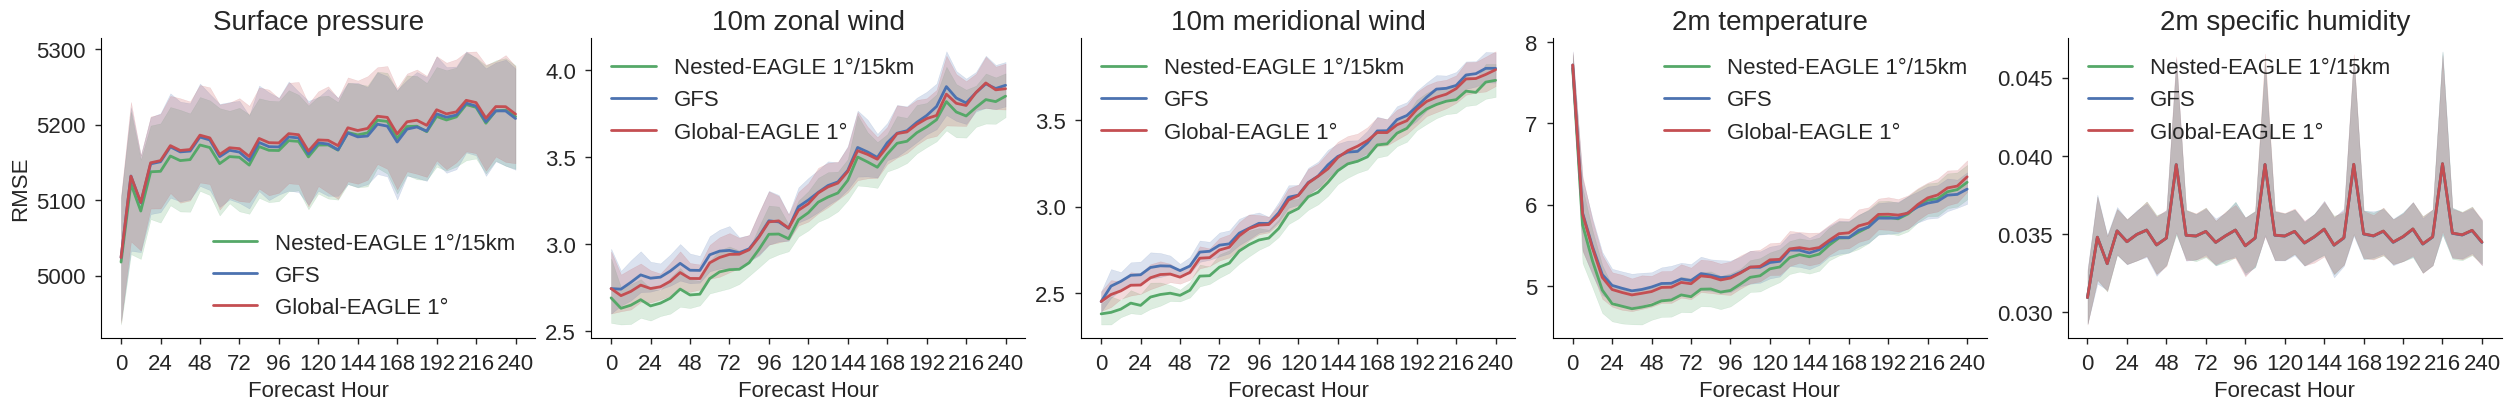

In [49]:
fig, axs = plot_surface_error(surface_fields)
#fig.savefig(f"figures/surface_10d_rmse_5fields.jpeg", dpi=300, bbox_inches="tight")

In [50]:
pressure_fields = ["geopotential_height", "zonal_wind", "meridional_wind", "temperature", "specific_humidity"]

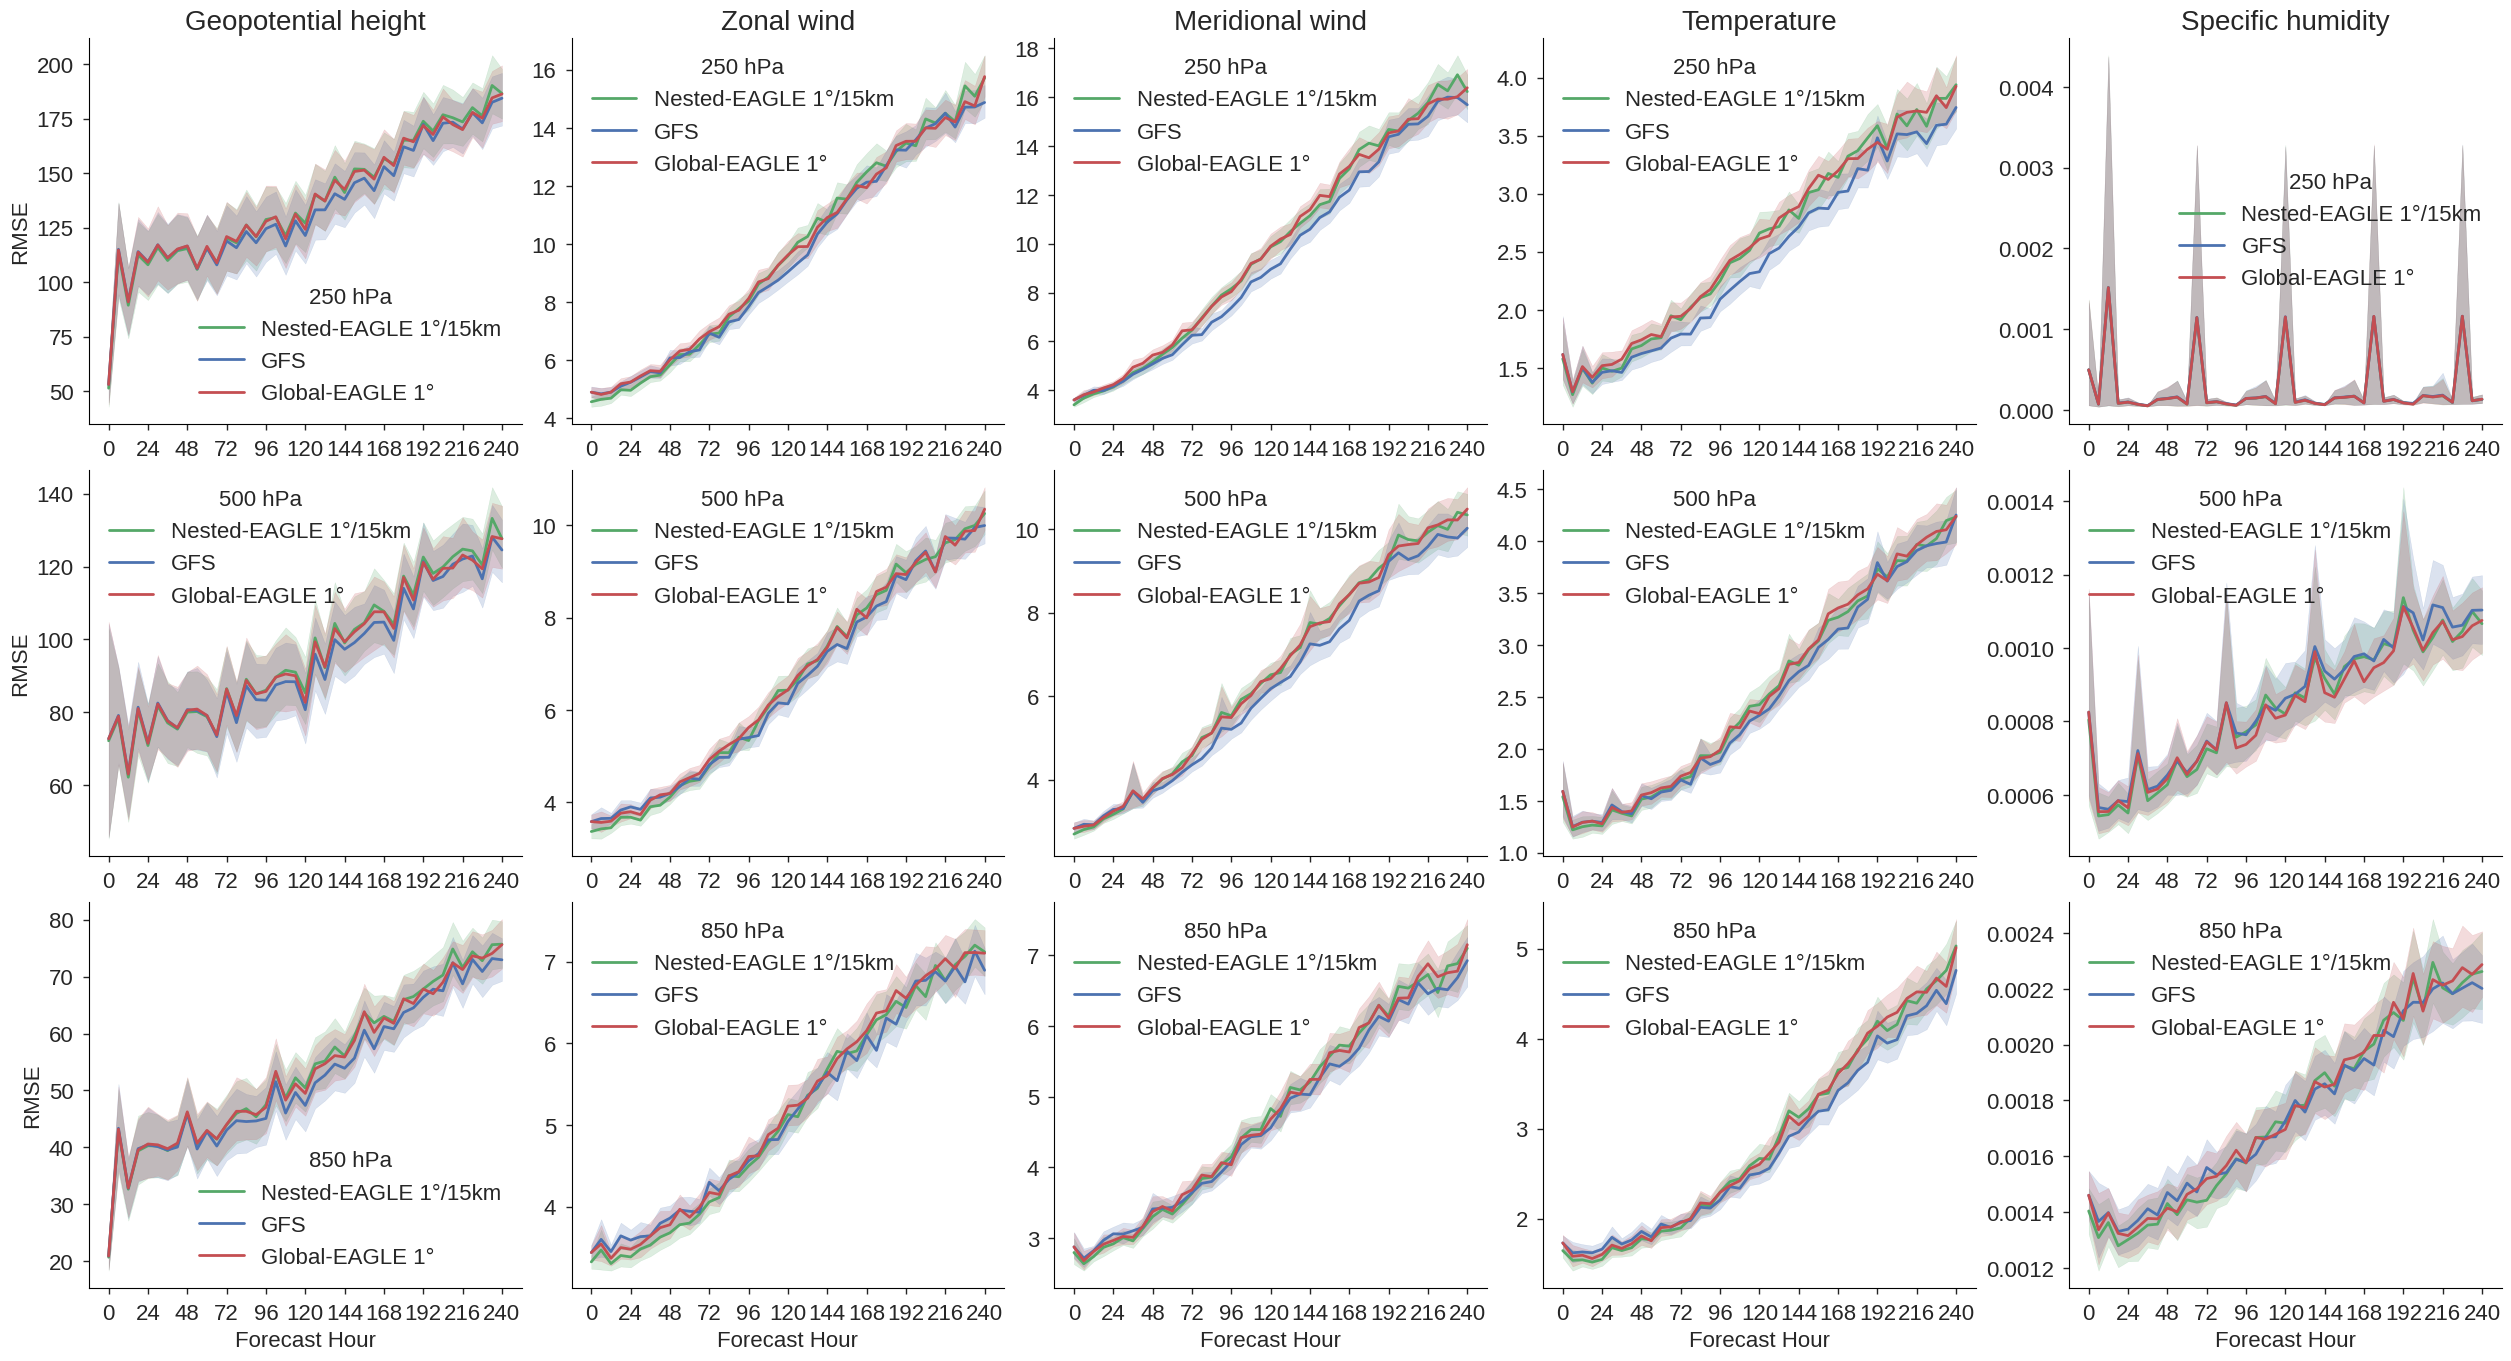

In [51]:
fig, axs = plot_level_vars(pressure_fields)
#fig.savefig(f"figures/plevel_10d_rmse_6fields.jpeg", dpi=300, bbox_inches="tight")